<a href="https://colab.research.google.com/github/RemanMahameed/Few_shot_captioning/blob/main/few_shot_captioning_LoRA_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q peft datasets transformers matplotlib

**Data Preparation**

In [ ]:
from datasets import load_dataset, DatasetDict
from transformers import AutoProcessor
import torch

# Load the dataset and select the first 700 images
ds = load_dataset("reach-vb/pokemon-blip-captions")
ds_700 = ds['train'].select(range(700))

# Split into Train (80%), Val (10%), Test (10%)
train_temp = ds_700.train_test_split(test_size=0.2, seed=42)
val_test = train_temp['test'].train_test_split(test_size=0.5, seed=42)

final_dataset = DatasetDict({
    'train': train_temp['train'],
    'validation': val_test['train'],
    'test': val_test['test']
})

# Load processor
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

def transforms(example_batch):
    images = list(example_batch["image"])
    captions = list(example_batch["text"])

    enc = processor(
        images=images,
        text=captions,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Mask padding in labels
    labels = enc["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    enc["labels"] = labels

    return enc

final_dataset["train"].set_transform(transforms)
final_dataset["validation"].set_transform(transforms)
final_dataset["test"].set_transform(transforms)

**Plotting and visualizing**

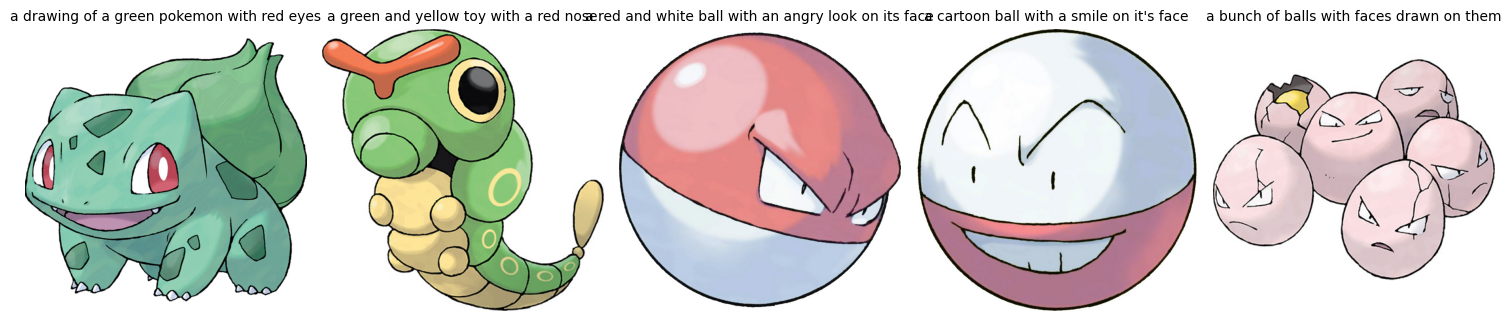

In [ ]:
import matplotlib.pyplot as plt

# The Fix: We use the raw ds_700 dataset here instead of final_dataset['train']
# because final_dataset has transformations applied that hide the 'image' column.
num_examples = 5
examples = ds_700.select(range(num_examples))

# Set up the plot grid
plt.figure(figsize=(15, 10))
for i, example in enumerate(examples):
    plt.subplot(1, num_examples, i + 1)

    image = example['image']
    caption = example['text']

    plt.imshow(image)
    plt.title(caption, fontsize=10, wrap=True)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Model and Text-Only LoRA Configuration**

In [ ]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType

# Load Base Model
model = AutoModelForCausalLM.from_pretrained(checkpoint)

# Define Text-Only LoRA Config
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "key", "value", "dense"]
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Loading weights:   0%|          | 0/305 [00:00<?, ?it/s]

GitForCausalLM LOAD REPORT from: microsoft/git-base
Key                                                    | Status     |  | 
-------------------------------------------------------+------------+--+-
git.embeddings.position_ids                            | UNEXPECTED |  | 
git.image_encoder.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


trainable params: 1,327,104 || all params: 177,946,170 || trainable%: 0.7458


# **Triaining**

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="git-pokemon-700-finetuned",
    learning_rate=4e-5,
    num_train_epochs=13,
    fp16=True,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    report_to="none",
    warmup_ratio=0.05,
    weight_decay=0.0
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],

)

# Train and Evaluate (loss only)
trainer.train()
trainer.evaluate()

# Save the trained LoRA weights
model.save_pretrained("git-pokemon-700-lora")
processor.save_pretrained("git-pokemon-700-lora")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss
1,5.640914,3.435897
2,3.549323,2.468445
3,2.370018,2.181886
4,2.144796,2.050218
5,1.920698,1.968803
6,1.842473,1.899157
7,1.793855,1.872964
8,1.706925,1.831332
9,1.689036,1.814698
10,1.625219,1.796571


['git-pokemon-700-lora/processor_config.json']

**6. Plotting Loss and BLEU Scores**

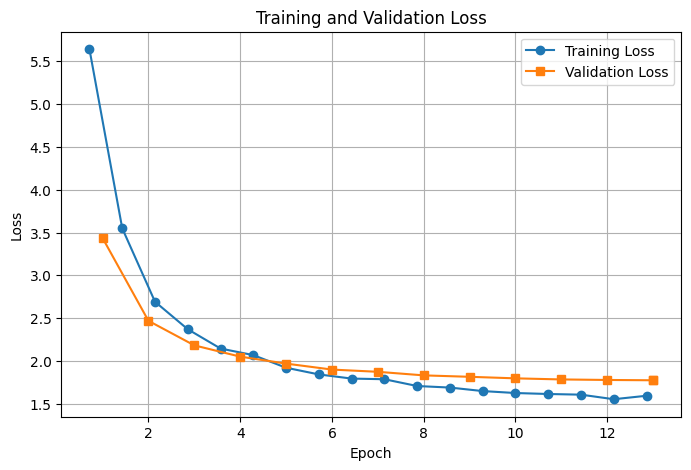

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_loss, val_loss = [], []
train_epochs, val_epochs = [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        val_loss.append(log["eval_loss"])
        val_epochs.append(log["epoch"])

plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker="o")
plt.plot(val_epochs, val_loss, label="Validation Loss", marker="s")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

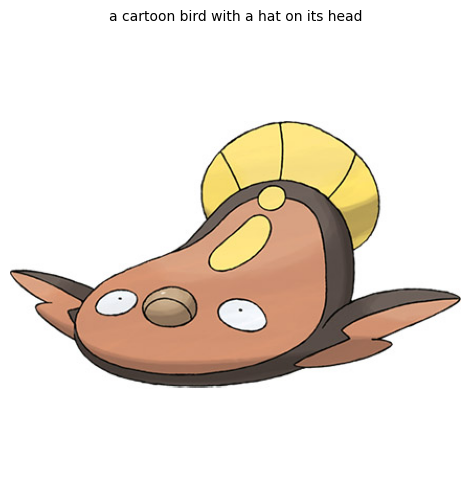

True caption: a cartoon bird with a hat on its head
drawing a with bird its on head a


In [ ]:
import torch
import matplotlib.pyplot as plt

# 1. Grab the specific example from the full dataset (index 650)
example = ds['train'][650]
image = example['image']       # PIL image object
true_caption = example['text']

# Visualize the true image and caption
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(true_caption, fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.show()

print("True caption:", true_caption)

# 2. Set device and move model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 3. Prepare inputs
inputs = processor(images=image, return_tensors="pt").to(device)

# 4. Generate prediction using tuned hyperparameters
generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    max_new_tokens=40,
    num_beams=2,              # was 4 or 5
    length_penalty=1.0,
    no_repeat_ngram_size=2,
    repetition_penalty=1.15,
    early_stopping=True,
)

# 5. Decode and print
pred = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(pred)